In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Đọc dữ liệu
df = pd.read_csv('dataset/dataset.csv')

df_ham = df[df['label'] == 0].copy()
df_spam = df[df['label'] == 1].copy()

## Tổng quan về bộ dữ liệu

In [7]:
# Kiểm tra thông tin chung về dữ liệu
print(df.info())

print('-'*50)
# Thống kê khuyết tại các cột
print('\nThống kê khuyết tại các cột:')
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   content           2603 non-null   object
 1   label             2603 non-null   int64 
 2   has_url           2603 non-null   int64 
 3   has_phone_number  2603 non-null   int64 
 4   sender_type       2603 non-null   object
dtypes: int64(3), object(2)
memory usage: 101.8+ KB
None
--------------------------------------------------

Thống kê khuyết tại các cột:
content             0
label               0
has_url             0
has_phone_number    0
sender_type         0
dtype: int64


In [8]:
# Kiểm tra trùng lặp
print('\nThống kê trùng lặp theo dòng dữ liệu:')
print(df.duplicated().sum())

print('\nThống kê trùng lặp theo cột content:')
print(df.duplicated(subset=['content']).sum())





Thống kê trùng lặp theo dòng dữ liệu:
0

Thống kê trùng lặp theo cột content:
0


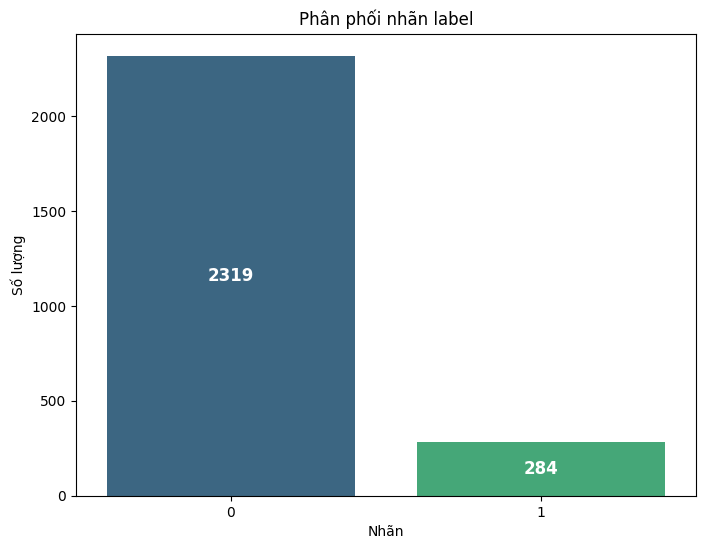

In [9]:
# Kiểm tra phân phối nhãn label
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df, x='label', hue='label', palette='viridis', legend=False)
plt.title('Phân phối nhãn label')
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')

# Thêm số liệu cụ thể vào giữa cột
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2, height / 2), 
                ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.show()


## Phân tích các đặc trưng có sẵn

### Phân loại URL và SĐT

Tỷ lệ tin nhắn có URL trong từng nhóm Spam và Ham

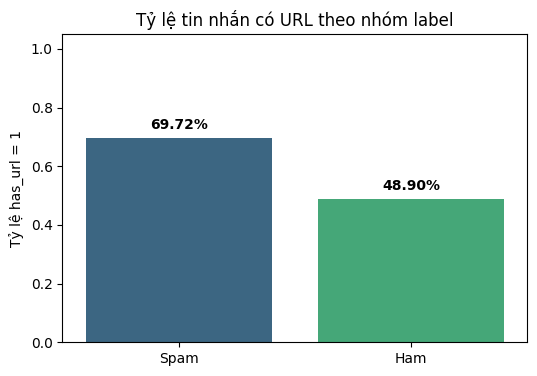

In [10]:
# Tính tỷ lệ tin nhắn có chứa URL trong từng nhóm
rate_spam_has_url = df_spam['has_url'].mean()
rate_ham_has_url = df_ham['has_url'].mean()

# Chuẩn bị dữ liệu để vẽ
rates = [rate_spam_has_url, rate_ham_has_url]
groups = ['Spam', 'Ham']

plt.figure(figsize=(6,4))
ax = sns.barplot(x=groups, y=rates, hue=groups, palette='viridis', legend=False)

# Thêm giá trị cụ thể lên mỗi cột
for i, v in enumerate(rates):
    ax.text(i, v + 0.02, f'{v:.2%}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 1.05)
plt.ylabel('Tỷ lệ has_url = 1')
plt.title('Tỷ lệ tin nhắn có URL theo nhóm label')
plt.show()



Tỷ lệ tin nhắn có SĐT trong từng nhóm Spam và Ham

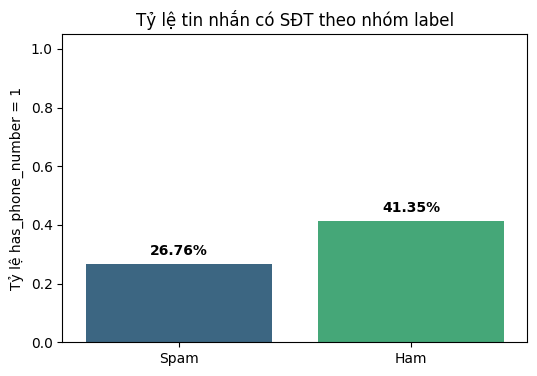

In [11]:
# Tính tỷ lệ tin nhắn có chứa URL trong từng nhóm
rate_spam_has_phone_number = df_spam['has_phone_number'].mean()
rate_ham_has_phone_number = df_ham['has_phone_number'].mean()

# Chuẩn bị dữ liệu để vẽ
rates = [rate_spam_has_phone_number, rate_ham_has_phone_number]
groups = ['Spam', 'Ham']

plt.figure(figsize=(6,4))
ax = sns.barplot(x=groups, y=rates, hue=groups, palette='viridis', legend=False)

# Thêm giá trị cụ thể lên mỗi cột
for i, v in enumerate(rates):
    ax.text(i, v + 0.02, f'{v:.2%}', ha='center', va='bottom', fontweight='bold')

plt.ylim(0, 1.05)
plt.ylabel('Tỷ lệ has_phone_number = 1')
plt.title('Tỷ lệ tin nhắn có SĐT theo nhóm label')
plt.show()



***Nhận xét:***

### Phân loại người gửi

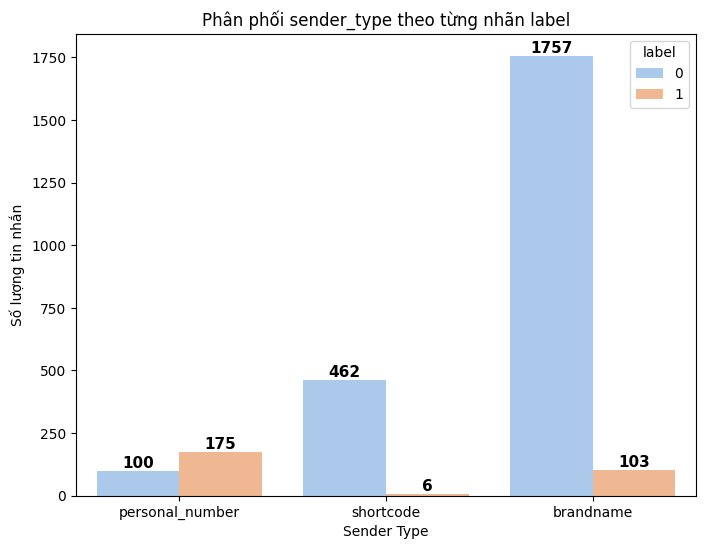

In [12]:
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df, x='sender_type', hue='label', palette='pastel')
plt.title('Phân phối sender_type theo từng nhãn label')
plt.xlabel('Sender Type')
plt.ylabel('Số lượng tin nhắn')
plt.legend(title='label', labels=[0, 1])

# Thêm số liệu trên đỉnh mỗi cột
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()


***Nhận xét:***

## Feature Engineering cơ bản (theo paper)

### Misspelled words

In [13]:
# === VIETNAMESE SPELL CHECKER IMPLEMENTATION ===

import json
import unicodedata
import re
from collections import defaultdict

# 1. NẠP DỮ LIỆU VÀ TẠO HASH SET
def load_dictionary(filepath):
    """
    Đọc file words.txt, chuẩn hóa Unicode (NFC), lưu vào Hash Set.
    """
    word_set = set()
    max_word_length = 0
    
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data = json.loads(line.strip())
                word = data.get('text', '')
                # Chuẩn hóa Unicode NFC
                word_normalized = unicodedata.normalize('NFC', word.lower())
                word_set.add(word_normalized)
                # Theo dõi độ dài từ dài nhất (tính theo số âm tiết)
                word_len = len(word_normalized.split())
                if word_len > max_word_length:
                    max_word_length = word_len
            except json.JSONDecodeError:
                continue
    
    return word_set, max_word_length

# 2. CHUẨN HÓA UNICODE VĂN BẢN ĐẦU VÀO
def normalize_text(text):
    """
    Chuẩn hóa Unicode văn bản người dùng nhập (NFC).
    """
    return unicodedata.normalize('NFC', text.lower())

# 3. THUẬT TOÁN LONGEST MATCHING ĐỂ TÁCH TỪ
def longest_matching_tokenize(text, word_set, max_word_length):
    """
    Dùng thuật toán Longest Matching để cắt văn bản thành các đơn vị từ.
    Trả về danh sách các tuple (từ, is_valid).
    """
    # Tách văn bản thành danh sách các âm tiết
    # Giữ lại các ký tự đặc biệt và số riêng biệt
    pattern = r'[a-zA-ZÀ-ỹ]+|[0-9]+|[^\s\w]'
    tokens = re.findall(pattern, text, re.UNICODE)
    
    result = []
    i = 0
    
    while i < len(tokens):
        matched = False
        # Thử từ độ dài dài nhất trước
        for length in range(min(max_word_length, len(tokens) - i), 0, -1):
            # Ghép các token liên tiếp thành một cụm từ
            candidate = ' '.join(tokens[i:i+length])
            candidate_normalized = normalize_text(candidate)
            
            if candidate_normalized in word_set:
                result.append((candidate, True))
                i += length
                matched = True
                break
        
        if not matched:
            # Từ đơn không có trong từ điển
            result.append((tokens[i], False))
            i += 1
    
    return result

# 4. TÍNH KHOẢNG CÁCH LEVENSHTEIN
def levenshtein_distance(s1, s2):
    """
    Tính khoảng cách Levenshtein giữa hai chuỗi.
    """
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

# 5. TÌM GỢI Ý TỪ ĐÚNG
def get_suggestions(misspelled_word, word_set, max_suggestions=5, max_distance=3):
    """
    Dùng Levenshtein để tìm những từ "gần giống nhất" trong từ điển.
    """
    misspelled_normalized = normalize_text(misspelled_word)
    suggestions = []
    
    for word in word_set:
        # Chỉ so sánh với các từ có độ dài tương tự
        if abs(len(word) - len(misspelled_normalized)) <= max_distance:
            distance = levenshtein_distance(misspelled_normalized, word)
            if distance <= max_distance:
                suggestions.append((word, distance))
    
    # Sắp xếp theo khoảng cách và trả về top gợi ý
    suggestions.sort(key=lambda x: x[1])
    return [word for word, dist in suggestions[:max_suggestions]]

# 6. HÀM KIỂM TRA CHÍNH TẢ TỔNG HỢP
def spell_check(text, word_set, max_word_length):
    """
    Kiểm tra chính tả văn bản đầu vào.
    Trả về danh sách từ sai và gợi ý sửa.
    """
    # Chuẩn hóa văn bản đầu vào
    normalized_text = normalize_text(text)
    
    # Tách từ bằng Longest Matching
    tokenized = longest_matching_tokenize(normalized_text, word_set, max_word_length)
    
    errors = []
    for word, is_valid in tokenized:
        if not is_valid:
            # Bỏ qua số và ký tự đặc biệt
            if re.match(r'^[a-zA-ZÀ-ỹ]+$', word, re.UNICODE):
                suggestions = get_suggestions(word, word_set)
                errors.append({
                    'word': word,
                    'suggestions': suggestions
                })
    
    return tokenized, errors

# === SỬ DỤNG ===

# Nạp từ điển
dict_path = 'Smishing/dicts/words.txt'  # Điều chỉnh đường dẫn nếu cần
word_set, max_word_length = load_dictionary(dict_path)
print(f"Đã nạp {len(word_set)} từ vào từ điển.")
print(f"Độ dài từ dài nhất: {max_word_length} âm tiết")

# Áp dụng cho DataFrame
def count_misspelled_vietnamese(text):
    """
    Đếm số từ sai chính tả trong văn bản tiếng Việt.
    """
    if not isinstance(text, str):
        return 0
    tokenized, errors = spell_check(text, word_set, max_word_length)
    return len(errors)

# Tạo cột mới với số từ sai chính tả
df_spam['num_misspelled_words_vi'] = df_spam['content'].apply(count_misspelled_vietnamese)
df_ham['num_misspelled_words_vi'] = df_ham['content'].apply(count_misspelled_vietnamese)

# Xem kết quả
df_spam[['content', 'num_misspelled_words_vi']].head(10)
df_ham[['content', 'num_misspelled_words_vi']].head(10)

Đã nạp 78267 từ vào từ điển.
Độ dài từ dài nhất: 24 âm tiết


C:\Users\duyng\AppData\Local\Temp\ipykernel_20612\478922341.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spam['num_misspelled_words_vi'] = df_spam['content'].apply(count_misspelled_vietnamese)


KeyboardInterrupt: 